In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#setup
import os, sys
current_path = os.path.abspath('')
parent_path = os.path.dirname(current_path)
source_path = f'{parent_path}\\src'
if not source_path in sys.path: sys.path.append(source_path)

#customs
# from data_model import *
# from data_helper import *
from config import *
setup()

Config finished!


In [3]:
in_names = ['X_train', 'X_val', 'y_train', 'y_val']
X_train, X_val, y_train, y_val = [pd.read_csv(f'./data/{name}.csv', index_col = 'Date', parse_dates=True) for name in in_names]

def reshape_input(X):
    return X

X_train, X_val = [reshape_input(X) for X in [X_train, X_val]]

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
def evaluate(model, X_val, y_val):
    y_val = y_val.reshape(y_val.shape[0], y_val.shape[1]) if len(y_val.shape) > 2 else y_val
    pred = model.predict(X_val)
    pred = pred.reshape(pred.shape[0], pred.shape[1]) if len(pred.shape) > 2 else pred

    mse = mean_squared_error(pred, y_val)
    mape = mean_absolute_percentage_error(pred, y_val)
    print('Result - MSE: ', mse, ' - MAPE: ', mape)

In [7]:
# SEED
from random import randint
seed_num = randint(0,10000)
# seed_num = 7548
from numpy.random import seed
seed(seed_num)
# tf.random.set_seed(seed_num)
# print('The seed is: ', seed_num)

# Stationary Test (dick fuller)

In [8]:
import statsmodels.api as sm

In [9]:
#stolen


# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80
def adfuller(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    print('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))

In [10]:
ts = X_train['y_lag_1'][1:]
adfuller(ts)

Time Series Analysis Plots
 Dickey-Fuller: p=0.00039


### NOTE:
Stationary !!! (p< 5% -> significant)

### Stationarity:
A stationary process has the property that the mean, variance and autocorrelation structure do not change over time. (needed for many models)

# ARIMA

In [12]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(start_p=8, max_p=9, suppress_warnings=True)
ts.index = ts.index.astype(int)
forecaster.fit(ts)
forecaster.summary()

F:\AppSSD\WorkTools\Anaconda\envs\sktime\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  after removing the cwd from sys.path.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1718
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6555.483
Date:                Sun, 13 Feb 2022   AIC                          13116.965
Time:                        08:49:35   BIC                          13133.310
Sample:                             0   HQIC                         13123.013
                               - 1718                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9066      0.014     64.003      0.000       0.879       0.934
ma.L1         -0.9820      0.008   -121.986      0.000      -0.998      -0.966
sigma2       121.2334      0.708    171.218      0.000     119.846     122.621
===================================================================================
Ljung-Box (L1) (Q):                   6.46   Jarque-Bera (JB):            684625.47
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               5.34   Skew:                            -8.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        99.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

F:\AppSSD\WorkTools\Anaconda\envs\sktime\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


Date
1627084800000000000    50.0
1627171200000000000    62.0
Name: y_lag_1, dtype: float64

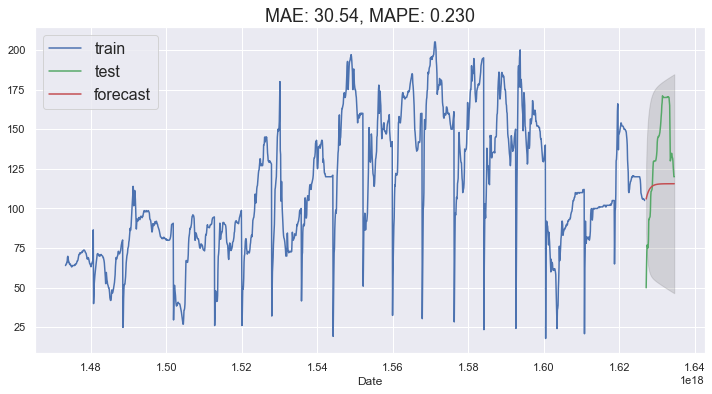

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#stolen

def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

ts_test = X_val['y_lag_1'][1:]
ts_test.index = ts_test.index.astype(int)
display(ts_test.head(2))
test_len = ts_test.shape[0]
fh = np.arange(test_len) + 1
forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05)
sun_arima_mae, sun_arima_mape = plot_forecast(
    ts, ts_test, forecast, forecast_int
)

# LightGBM

In [14]:
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
import lightgbm as lgb

def create_forecaster():
    
    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
    
    return forecaster

def grid_serch_forecaster(train, test, forecaster, param_grid):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")
    
    # forecasting
    fh=np.arange(len(test))+1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape
    

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
param_grid = {"window_length": [5]} # parameter set to be grid searched
forecaster = create_forecaster()


In [ ]:
X_train.head(1)

,LeagueDay,day_of_week,month,y_lag_1,y_lag_2,y_lag_3,y_lag_4,rolling_mean,rolling_min,rolling_max,general_rolling_mean,general_rolling_min,general_rolling_max,expanding_mean,expanding_max,expanding_min
Date,,,,,,,,,,,,,,,,
2016-09-08,1.0,3,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sun_lgb_mae, sun_lgb_mape = grid_serch_forecaster(
    np.nan_to_num(ts), 
    np.nan_to_num(ts_test),  
    forecaster, 
    param_grid
)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000020 seconds, init for row-wise cost 0.001210 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1265
[LightGBM] [Info] Number of data points in the train set: 1197, number of used features: 5
[LightGBM] [Info] Start training from score 106.807788
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trai

In [ ]:
np.where(np.isnan(ts))